In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install SimpleITK

     |████████████████████████████████| 47.4MB 101kB/s 


In [ ]:
from __future__ import print_function, division
import SimpleITK as sitk
import cv2
import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import os
try:
    from tqdm import tqdm # long waits are not fun
except:
    tqdm = lambda x: x

#Some helper functions

TypeError: ignored

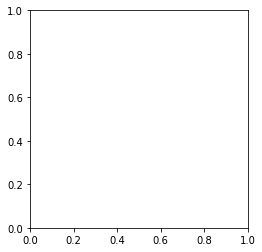

In [ ]:
luna_path = 'gdrive/My Drive/luna/'
luna_subset_path ='gdrive/My Drive/luna/subset0/'
output_path = 'gdrive/My Drive/luna/output/'
file_list=glob(luna_subset_path+"*.mhd")
csv='gdrive/My Drive/luna/CSVFILES/annotations.csv'
#plt.imshow('gdrive/My Drive/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
#a='gdrive/My Drive/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd')
b='/content/gdrive/MyDrive/luna/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.mhd'
c=cv2.imread(b)
plt.imshow(c)

In [ ]:
def make_mask(center,diam,z,width,height,spacing,origin):
    #'''
#Center : centers of circles px -- list of coordinates x,y,z
#diam : diameters of circles px -- diameter
#widthXheight : pixel dim of image
#spacing = mm/px conversion rate np array x,y,z
#origin = x,y,z mm np.array
#z = z position of slice in world coordinates mm
    #'''
    mask = np.zeros([height,width]) # 0's everywhere except nodule swapping x,y to match img
    #convert to nodule space from world coordinates

    # Defining the voxel range in which the nodule falls
    v_center = (center-origin)/spacing
    v_diam = int(diam/spacing[0]+5)
    v_xmin = np.max([0,int(v_center[0]-v_diam)-5])
    v_xmax = np.min([width-1,int(v_center[0]+v_diam)+5])
    v_ymin = np.max([0,int(v_center[1]-v_diam)-5])
    v_ymax = np.min([height-1,int(v_center[1]+v_diam)+5])

    v_xrange = range(v_xmin,v_xmax+1)
    v_yrange = range(v_ymin,v_ymax+1)

    # Convert back to world coordinates for distance calculation
    x_data = [x*spacing[0]+origin[0] for x in range(width)]
    y_data = [x*spacing[1]+origin[1] for x in range(height)]

    # Fill in 1 within sphere around nodule
    for v_x in v_xrange:
        for v_y in v_yrange:
            p_x = spacing[0]*v_x + origin[0]
            p_y = spacing[1]*v_y + origin[1]
            if np.linalg.norm(center-np.array([p_x,p_y,z]))<=diam:
                mask[int((p_y-origin[1])/spacing[1]),int((p_x-origin[0])/spacing[0])] = 1.0
        return(mask)


In [ ]:
def matrix2int16(matrix):
    '''
matrix must be a numpy array NXN
Returns uint16 version
    '''

    m_min= np.min(matrix)
    m_max= np.max(matrix)
    matrix = matrix-m_min
    return(np.array(np.rint( (matrix-m_min)/float(m_max-m_min) * 65535.0),dtype=np.uint16))


In [ ]:
def normalizePlanes(npzarray):
    maxHU = 400.  #Rupa: can be changed????
    minHU = -1000. #Rupa: can be changed????
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    npzarray *= 255
    return npzarray.astype(int)

  0%|          | 0/46 [00:00<?, ?it/s]

reading csv...
looping over the image files...


TypeError: ignored

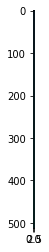

In [ ]:
## Getting list of image files
# Helper function to get rows in data frame associated
# with each file
def get_filename(file_list, case):
    for f in file_list:
        if case in f:
            return(f)
#
# The locations of the nodes
print ('reading csv...')
df_node = pd.read_csv(csv)
df_node["file"] = df_node["seriesuid"].map(lambda file_name: get_filename(file_list, file_name))
df_node = df_node.dropna()
rupa=0
print('looping over the image files...')
for fcount, img_file in enumerate(tqdm(file_list)):
    mini_df = df_node[df_node["file"]==img_file] #get all nodules associate with file
    if mini_df.shape[0]>0: # some files may not have a nodule--skipping those
        # load the data once
        itk_img = sitk.ReadImage(img_file)
        
        img_array = sitk.GetArrayFromImage(itk_img) # indexes are z,y,x (notice the ordering)
        
        num_z, height, width = img_array.shape        #heightXwidth constitute the transverse plane
        origin = np.array(itk_img.GetOrigin())      # x,y,z  Origin in world coordinates (mm)
        spacing = np.array(itk_img.GetSpacing())    # spacing of voxels in world coor. (mm)
        #print(img_array)
        #plt.imshow(img_array.T)
        if (fcount==3):
              break
        # go through all nodes (why just the biggest?)
        for node_idx, cur_row in mini_df.iterrows():
            node_x = cur_row["coordX"]
            node_y = cur_row["coordY"]
            node_z = cur_row["coordZ"]
            diam = cur_row["diameter_mm"]
            # just keep 3 slices
            imgs = np.ndarray([height,width,3],dtype=np.float32)
            plt.imshow(imgs[2])
            masks = np.ndarray([3,height,width],dtype=np.uint8)
            center = np.array([node_x, node_y, node_z])   # nodule center
            v_center = np.rint((center-origin)/spacing)  # nodule center in voxel space (still x,y,z ordering)
            for i, i_z in enumerate(np.arange(int(v_center[2])-1,
                             int(v_center[2])+2).clip(0, num_z-1)): # clip prevents going out of bounds in Z
                mask = make_mask(center, diam, i_z*spacing[2]+origin[2],
                                 width, height, spacing, origin)
                masks[i] = mask
                #plt.imshow( masks[0,:,:])
                #plt.savefig('gdrive/My Drive/luna/images/masks[0,:,:].png')
#                 imgs[i] = img_array[i_z]
                masks[i] = normalizePlanes(img_array[i_z])
            #plt.imshow(imgs.T)
            
            #plt.imshow(imgs.T)
            np.save(os.path.join(output_path,"images_%04d_%04d.npy" % (fcount, node_idx)),imgs)
            np.save(os.path.join(output_path,"masks_%04d_%04d.npy" % (fcount, node_idx)),masks)
            print('done saving images/masks_%04d_%04d' % (fcount, node_idx))
print('process done...')

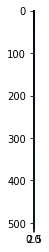

In [ ]:
plt.imshow( imgs[0])
